# Tuning Curves and Place Cells

## Exercise 3 - Working with Real Data

First we import the necessary libraries and download the mouse data.

In [226]:
import numpy as np
from heapq import nsmallest
from heapq import nlargest
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

In [227]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/FeDX3LfbJ4pC7T6')

In [228]:
with open('data/linear_track_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

x = data['x']
t = data['t']
spikes = data['spikes']

### A

Here the position of the mouse is plotted as a function of time. 

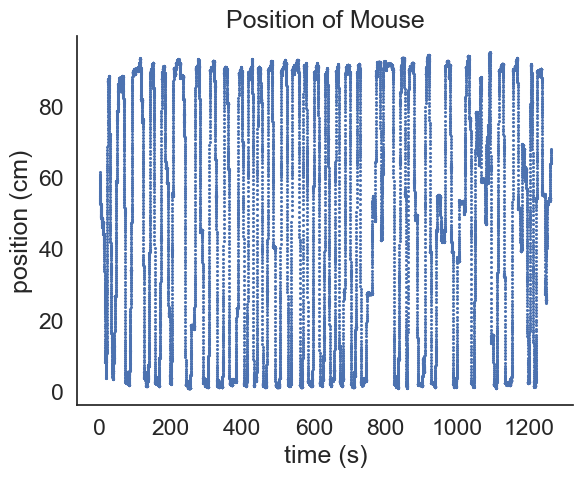

In [229]:
plt.scatter(t, x, s = 1.2** 2.)
plt.xlabel('time (s)')
plt.ylabel('position (cm)')
plt.title('Position of Mouse')
plt.show()

Next the spiking behaviour of the first neuron is plotted as a puntion of time and position. The np.interp function is used to interpolate the spike times.

In [230]:
s_f = np.interp(spikes[0],t, x) 

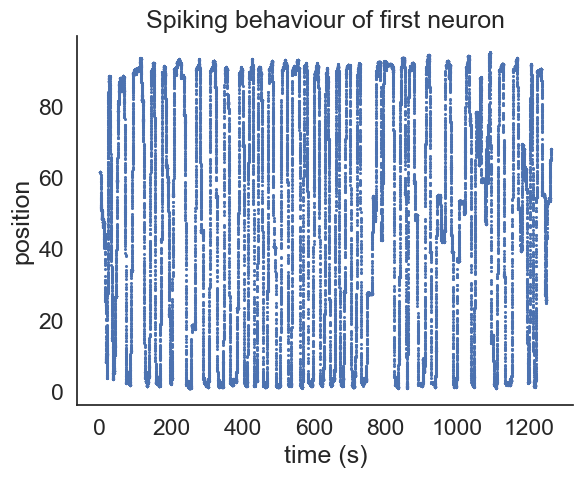

In [231]:
plt.scatter(spikes[0], s_f, s = 1.2** 2.)
plt.xlabel('time (s)')
plt.ylabel('position')
plt.title('Spiking behaviour of first neuron')
plt.show()

### B

To help understand further analysis results the spiking behaviour of all cells is plotted first below. 

In [232]:
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

The firing rate maps are plotted below. When looking at the spiking behaviour plotted above, correspondance with the firing rate maps is visible. 

In [233]:
spike_positions = [np.interp(s, t, x) for s in spikes]

In [234]:
fps = 30
space_bins = np.arange(0., 100., 5.)

# compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# occupancy histogram 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

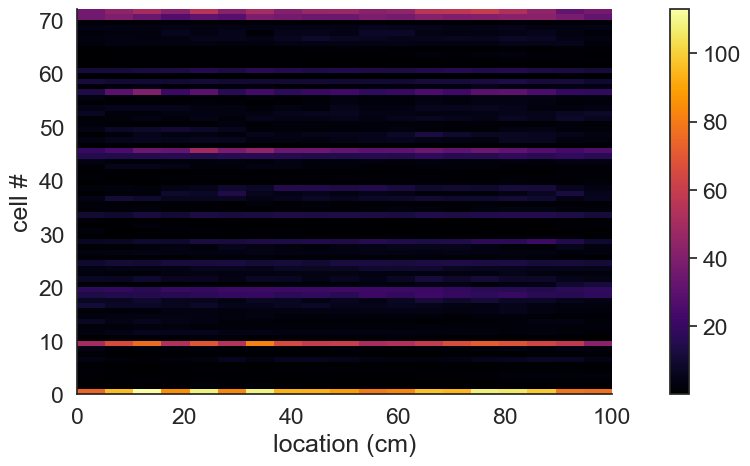

In [235]:
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 100, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Next the firing rate maps sorted by increasing peak position are plotted below.

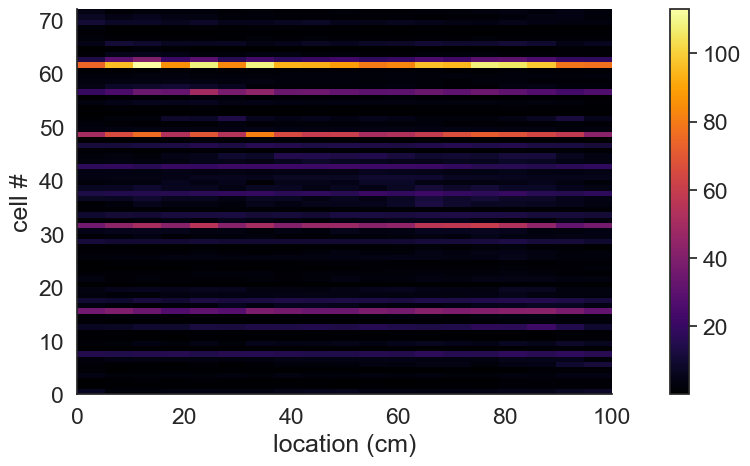

In [236]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 100, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

### C

The spatial information for each cell is calculated using the given equations:

$$ I = \sum_x \lambda(x) \log_2 \frac{\lambda(x) + \epsilon}{\lambda} p_{occ}(x) $$ $$ I_s = \frac{I}{\lambda}$$

In [237]:
average_neuron =  np.sum(firing_rate_maps, 1)/19 # average neuron fire rates

average_list = [] # making a list of lists of average values to fit the shape of the firing rate maps list
for i in range(72):
    values = [average_neuron[i]]*19
    average_list.append(values)
    


In [238]:
# spatial information according to the first equation
space_info = np.sum(firing_rate_maps*np.log2((firing_rate_maps+10**(-15))*occupancy/(average_list)), 1)

# alternate spatial information according to the second equation, better suited for place cells 
alt_space_info = space_info/average_neuron

The spatial information is plotted according to both equations.

<function matplotlib.pyplot.show(close=None, block=None)>

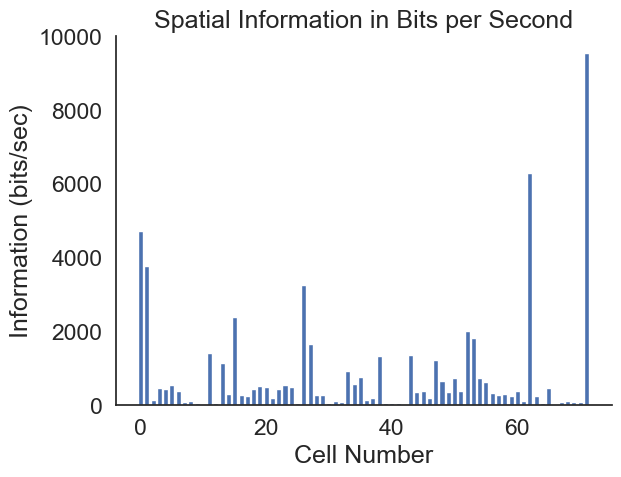

In [239]:
plt.bar(range(0,72),space_info)
plt.xlabel('Cell Number')
plt.ylabel('Information (bits/sec)')
plt.title('Spatial Information in Bits per Second')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

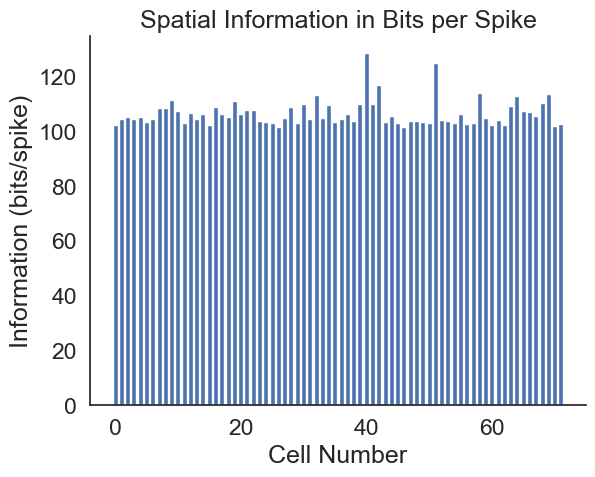

In [240]:
plt.bar(range(0,72),alt_space_info)
plt.xlabel('Cell Number')
plt.ylabel('Information (bits/spike)')
plt.title('Spatial Information in Bits per Spike')
plt.show

Next the lowest and highest spatial information cells from the last plot are determined. For the lowest these are cells 0, 26, 46, 60, 70, and for the highest these are 40, 42, 51, 58, 69. Firing rate maps are then plotted for these cells.

In [241]:
lowvalues = nsmallest(5, alt_space_info)
lowpositions = [i for i, v in enumerate(alt_space_info) if v in lowvalues]
print(lowpositions)

highvalues = nlargest(5, alt_space_info)
highpositions = [i for i, v in enumerate(alt_space_info) if v in highvalues]
print(highpositions)

[0, 26, 46, 60, 70]
[40, 42, 51, 58, 69]


In [245]:
lowspikes = [spikes[0],spikes[26], spikes[46], spikes[60], spikes[70]]
lowspike_positions = [np.interp(s, t, x) for s in lowspikes]

fps = 30
space_bins = np.arange(0., 100., 5.)

lowspikes_hist= [np.histogram(s, space_bins)[0] for s in lowspike_positions]

lowspikes_hist = np.vstack(lowspikes_hist).astype(np.float64)

lowoccupancy = np.histogram(x, space_bins)[0] /  fps

lowfiring_rate_maps = lowspikes_hist / lowoccupancy 

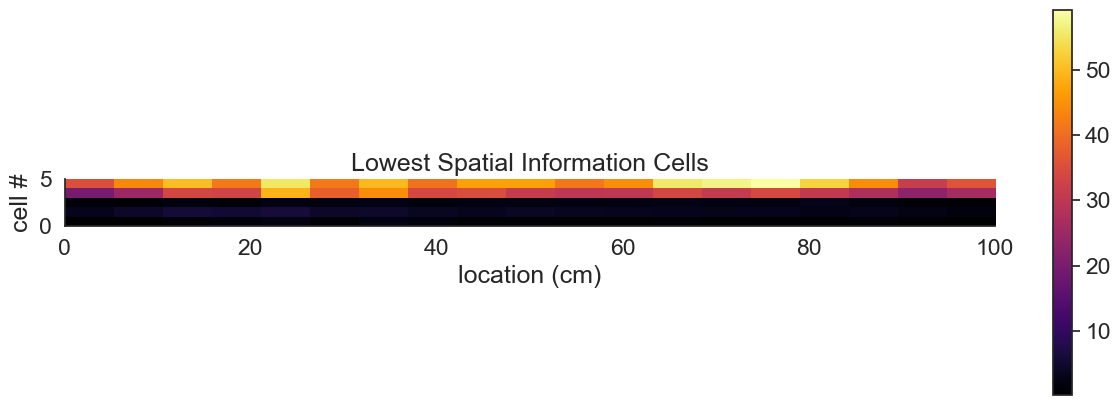

In [249]:
plt.figure(figsize=(15,5))
plt.imshow(lowfiring_rate_maps, cmap='inferno', extent = [0, 100, 0, 5])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Lowest Spatial Information Cells')
plt.colorbar()

In [247]:
highspikes = [spikes[40],spikes[42], spikes[51], spikes[58], spikes[69]]
highspike_positions = [np.interp(s, t, x) for s in highspikes]

fps = 30
space_bins = np.arange(0., 100., 5.)

highspikes_hist= [np.histogram(s, space_bins)[0] for s in highspike_positions]

highspikes_hist = np.vstack(highspikes_hist).astype(np.float64)

highoccupancy = np.histogram(x, space_bins)[0] /  fps

highfiring_rate_maps = highspikes_hist / highoccupancy 

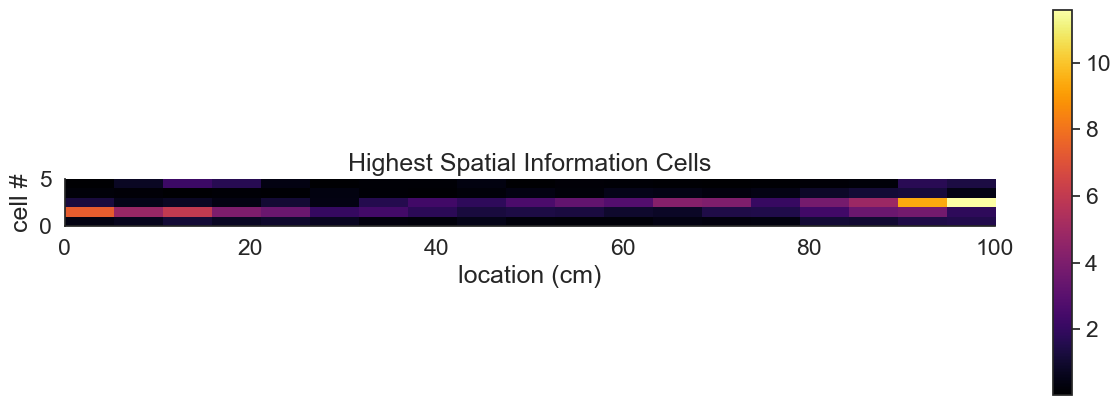

In [251]:
plt.figure(figsize=(15,5))
plt.imshow(highfiring_rate_maps, cmap='inferno', extent = [0, 100, 0, 5])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Highest Spatial Information Cells')
plt.colorbar()

A striking difference between the maps is that the high spatial spatial information cells have a way slower fire rate than the low spatial information cells. Form this can be concluded that a higher fire rate does not necessary correspond to higher spatial information. 